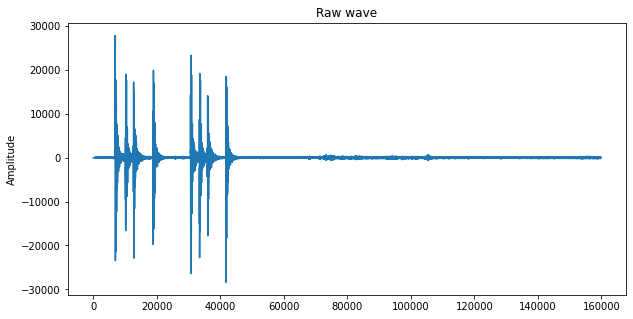

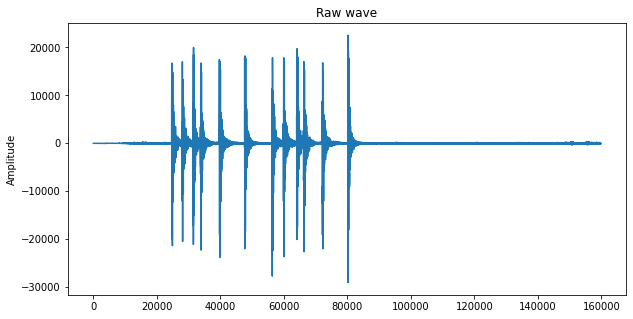

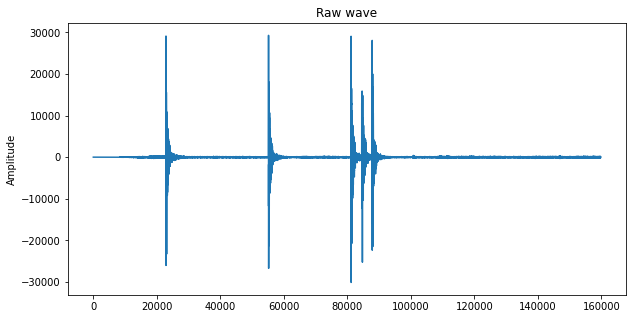

In [1]:
# Open wav file and load into numpy array
import numpy as np
import wave
import matplotlib.pyplot as plt
import os

dataFolder = "data/audio/"

def load_wav_file(filename):
    wav = wave.open(filename, "r")
    frames = wav.readframes(-1)
    sound_info = np.frombuffer(frames, "int16")
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate

def plot_wav_file(sound_info):
    plt.figure(num=None, figsize=(10, 5))
    plt.title('Raw wave')
    plt.ylabel('Amplitude')
    plt.plot(sound_info)
    plt.show()


signals = []

for filename in os.listdir(dataFolder):
    if filename.endswith(".wav"):
        signals.append(load_wav_file(dataFolder + filename)[0])

# Plot the first, second, and 10th audio file
plot_wav_file(signals[0])
plot_wav_file(signals[1])
plot_wav_file(signals[9])
    




In [2]:
# Normalize the audio files so that 30000 is now 1
# This is so that we can compare the audio files
# to each other
def normalize_audio(signal):
    return signal / 30000

normalized_signals = []

for signal in signals:
    normalized_signals.append(normalize_audio(signal))


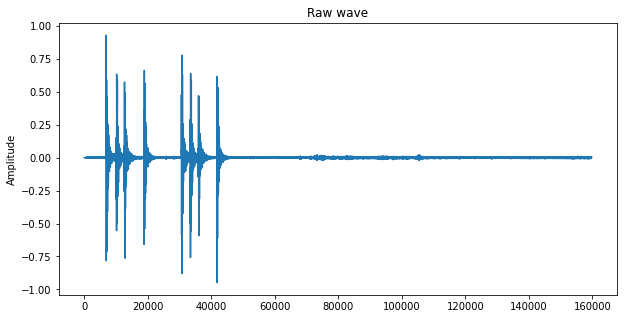

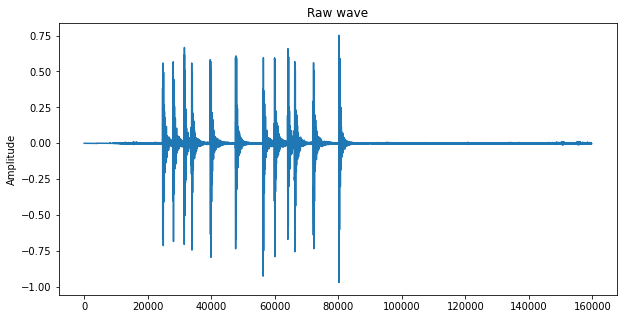

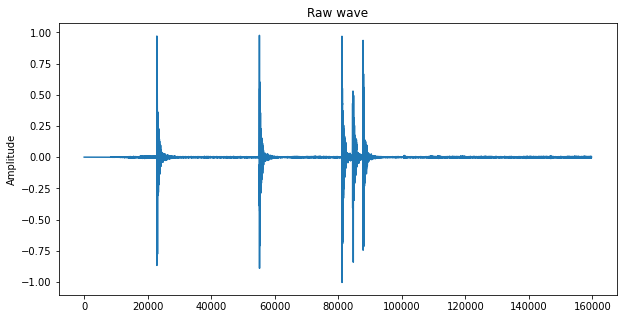

In [3]:
# Plot the first, second, and 10th audio file
plot_wav_file(normalized_signals[0])
plot_wav_file(normalized_signals[1])
plot_wav_file(normalized_signals[9])

In [5]:
# Make a autoencoder model to compress the audio signal
from tensorflow.keras.layers import Input, Dense

# Input layer
input_layer = Input(shape=(len(signals[0]),))
# Encoder layers
encoded = Dense(2000, activation="tanh")(input_layer)
encoded = Dense(1000, activation="tanh")(encoded)
encoded = Dense(500, activation="tanh")(encoded)
# Latent view
latent_view = Dense(250, activation="tanh")(encoded)
# Decoder layers
decoded = Dense(500, activation="tanh")(latent_view)
decoded = Dense(1000, activation="tanh")(decoded)
decoded = Dense(2000, activation="tanh")(decoded)
# Output layer set range to 0 to 30000
output_layer = Dense(len(signals[0]), activation="tanh")(decoded)

# Compile the model
from tensorflow.keras.models import Model

autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.summary()

# Save model every 100 epochs
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_name = "modelCheckpoints/Weights-{epoch:03d}--{val_loss:.5f}.hdf5"
checkpoint = ModelCheckpoint(checkpoint_name, monitor="val_loss", verbose=1, save_best_only=True, mode="auto")
callbacks_list = [checkpoint]

# Train the model
autoencoder.fit(np.array(normalized_signals), np.array(normalized_signals), epochs=10000, batch_size=5, shuffle=True, validation_split=0.2, callbacks=callbacks_list)

# Plot the loss
plt.plot(autoencoder.history.history["loss"], label="Training loss")




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 159744)]          0         
                                                                 
 dense (Dense)               (None, 2000)              319490000 
                                                                 
 dense_1 (Dense)             (None, 1000)              2001000   
                                                                 
 dense_2 (Dense)             (None, 500)               500500    
                                                                 
 dense_3 (Dense)             (None, 250)               125250    
                                                                 
 dense_4 (Dense)             (None, 500)               125500    
                                                                 
 dense_5 (Dense)             (None, 1000)              501000

1/1 [==============================] - 0s 87ms/step


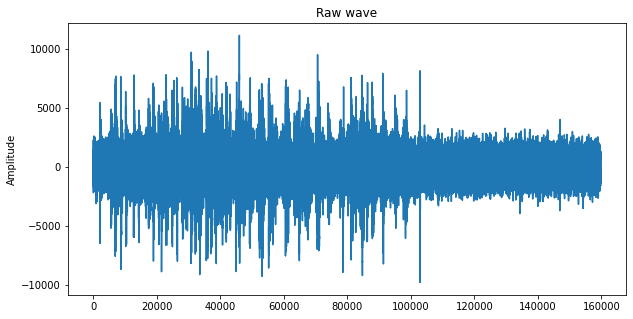

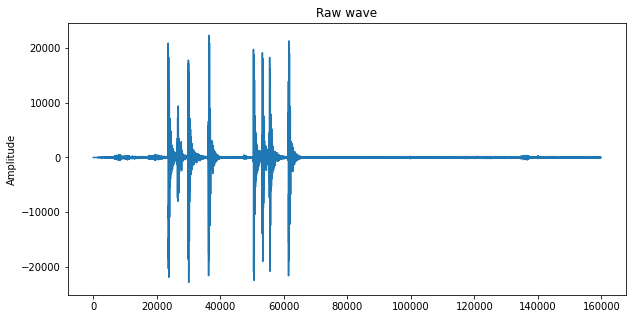

In [ ]:
nthPred = 21

# Predict the compressed signal from the first audio file
compressed_signal = autoencoder.predict(np.array([normalized_signals[nthPred]]))

# Save the compressed signal
compressed_signal = compressed_signal[0] * 30000
compressed_signal = np.array(compressed_signal, dtype=np.int16)
wavefile = wave.open("compressed_signal.wav", "w")
wavefile.setnchannels(1)
wavefile.setsampwidth(2)
wavefile.setframerate(20000)
wavefile.writeframes(compressed_signal)
wavefile.close()


# Plot the compressed signal
plot_wav_file(compressed_signal)

# plot the original signal
plot_wav_file(normalized_signals[nthPred] * 30000)